In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.describe()

,objID,z,uMAG,rMAG,u-r,SVMPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,-18.495233,-20.575399,2.080166,0.558053
std,6.022167e+12,0.023058,1.034802,1.140994,0.610873,0.496619
min,1.237646e+18,0.003001,-26.045010,-25.957740,-3.803460,0.000000
25%,1.237658e+18,0.045979,-19.147785,-21.304710,1.660000,0.000000
50%,1.237662e+18,0.067202,-18.601710,-20.713750,2.158930,1.000000
75%,1.237665e+18,0.082217,-18.002450,-20.047520,2.500980,1.000000
max,1.237680e+18,0.100000,54.116670,-13.083160,78.125900,1.000000


In [28]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50) & (df['rMAG']>-22)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=3000)

Dataframe size post-cut: 90000


In [29]:
max(df['uMAG'])

-10.74593

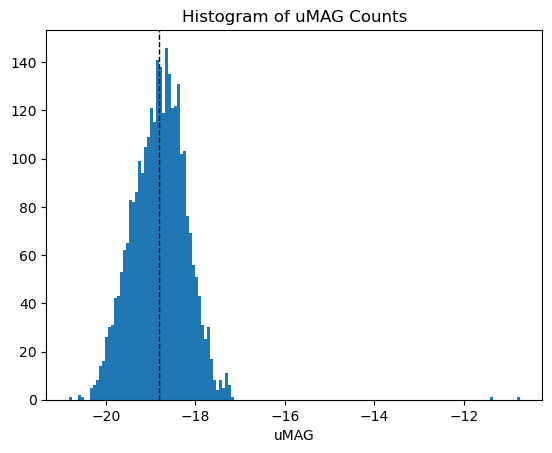

-19.595856 -18.080334


In [30]:
plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

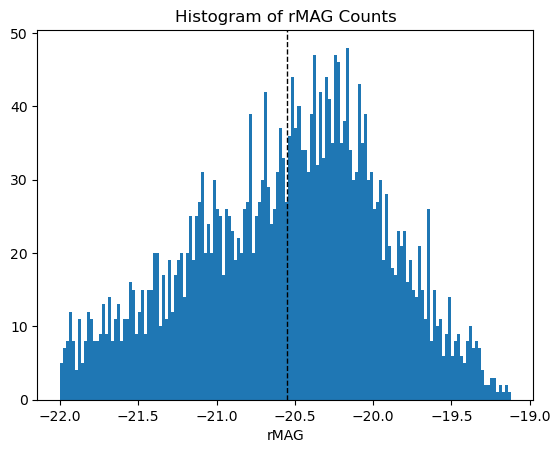

In [31]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

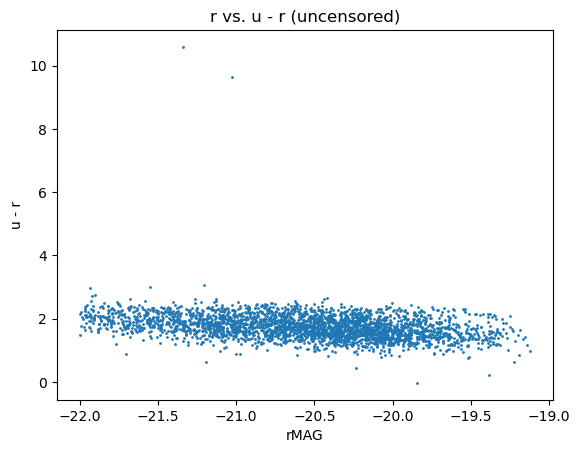

In [32]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (uncensored)")
plt.show()

In [33]:
# Adding censored data column for -19.5 < uMAG < -18.1
print(len(df[df["uMAG"]>-18]))
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.5) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.5):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

237


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored,censored_u-r
179726,1237655369827549316,0.074838,-18.40290,-20.74093,2.33803,1,-18.40290,0.0,2.33803
256638,1237662661602836608,0.078771,-19.23304,-21.40679,2.17375,1,-19.23304,0.0,2.17375
196984,1237662238011949226,0.060862,-19.69524,-21.13109,1.43585,1,-19.50000,1.0,1.63109
117811,1237648722300371225,0.064053,-18.65725,-20.19179,1.53454,1,-18.65725,0.0,1.53454
304011,1237652600639783541,0.060774,-18.15529,-19.80292,1.64763,1,-18.15529,0.0,1.64763


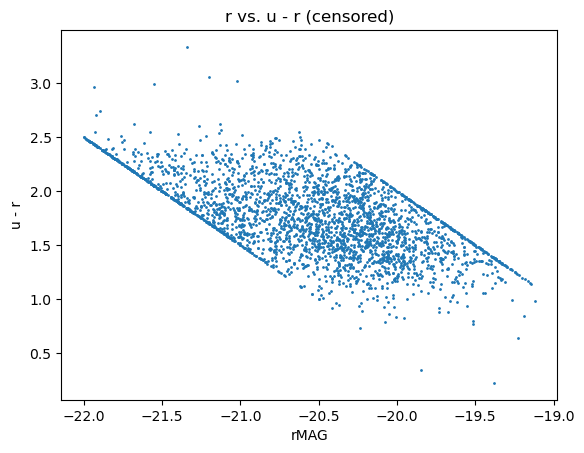

In [34]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (censored)")
plt.show()

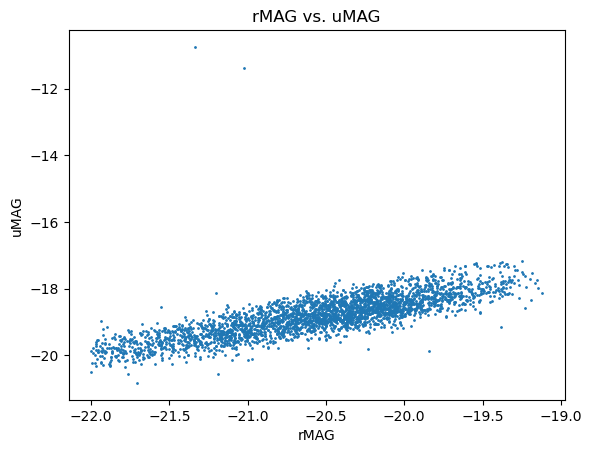

In [35]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('rMAG vs. uMAG')
plt.show()

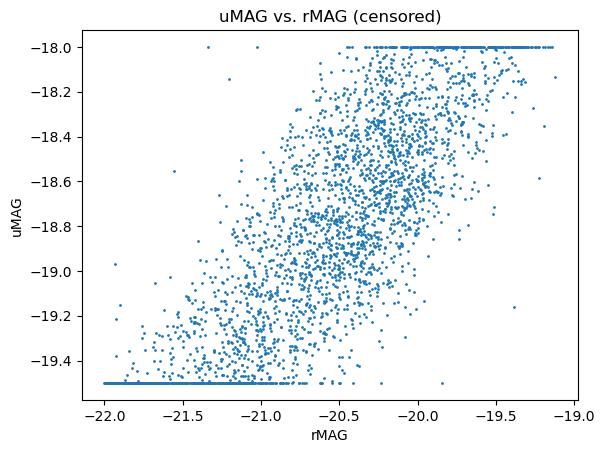

In [36]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

# `r vs u - r (uncensored)`

In [37]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model

In [38]:
# Minimum Effective Sample Size for model - we have 9: mean, lb, ub for slope, intercept, and sigma
import pymc as pm
import arviz as az
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

N_sample = minESS(9).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8823


In [39]:
q1_model = lregression(df['rMAG'], df['u-r'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = N_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 153 seconds.


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

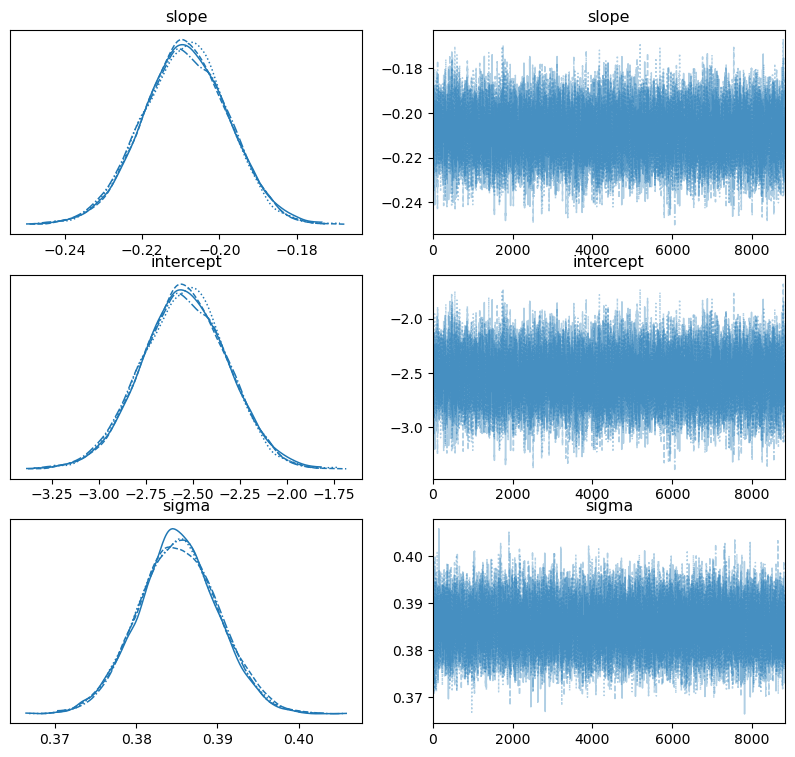

In [40]:
az.plot_trace(q1_fit, figsize=[10,9])

In [41]:
slope3=np.percentile(np.array(q1_fit["posterior"]["slope"])[0],3)
slope97=np.percentile(np.array(q1_fit["posterior"]["slope"])[0],97)
intercept3=np.percentile(np.array(q1_fit["posterior"]["intercept"])[0],3)
intercept97=np.percentile(np.array(q1_fit["posterior"]["intercept"])[0],97)
print(slope3,slope97,intercept3,intercept97)

-0.2298581634072963 -0.18755660848446193 -2.976338548417844 -2.1084093155051056


In [42]:
summ=az.summary(q1_fit)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.209,0.011,-0.229,-0.188,0.000,0.000,10843.0,12510.0,1.0
intercept,-2.545,0.228,-2.963,-2.107,0.002,0.002,10845.0,12526.0,1.0
sigma,0.385,0.005,0.376,0.395,0.000,0.000,15761.0,15562.0,1.0


In [43]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="red", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")

[Text(0.5, 1.0, 'r vs u-r (uncensored data) fit'),
 Text(0.5, 0, 'r'),
 Text(0, 0.5, 'u-r')]

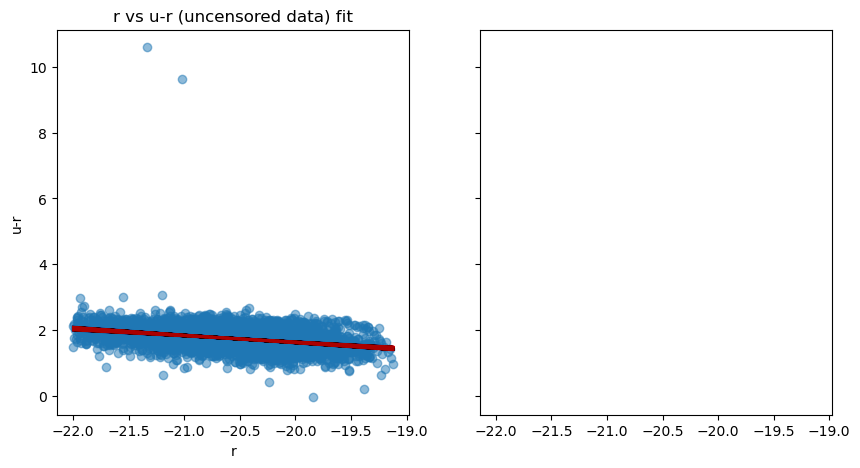

In [44]:
x=np.linspace(-22,-19,50)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True) # Everything breaks if we have a 1x1 plot grid. Dunno why.
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (uncensored data) fit",xlabel="r",ylabel="u-r")

# `u-r vs r (censored)`

In [45]:
df['uMAG'].describe()

count    3000.000000
mean      -18.804434
std         0.617011
min       -20.830750
25%       -19.220970
50%       -18.780035
75%       -18.396810
max       -10.745930
Name: uMAG, dtype: float64

In [46]:
# Defining Censored Model
def censored_regression(x, y):
    with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)

        start = pm.find_MAP()
        step = pm.NUTS()
    return model

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_99287/3051048762.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_99287/3051048762.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


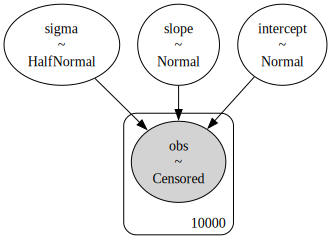

In [62]:
# Model to Visual
x = df['rMAG']
y = df['censored_uMAG']
with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)
from pymc import Model, Normal, Gamma,model_to_graphviz
model_to_graphviz(model)

In [63]:
# Running MCMC Simulatoins
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(N_sample, init="adapt_diag", step=pm.NUTS())

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_99287/1167654549.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_99287/1167654549.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 992 seconds.


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

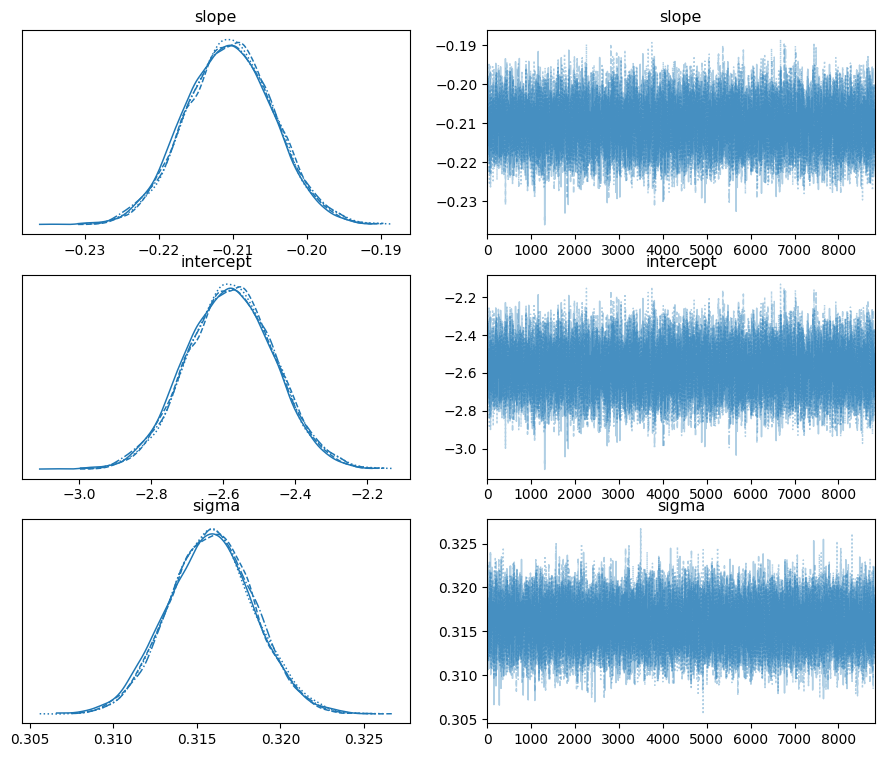

In [80]:
# Visualizing Trace
az.plot_trace(censored_fit,figsize=[11,9])

array([<Axes: title={'center': 'slope'}>,
       <Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

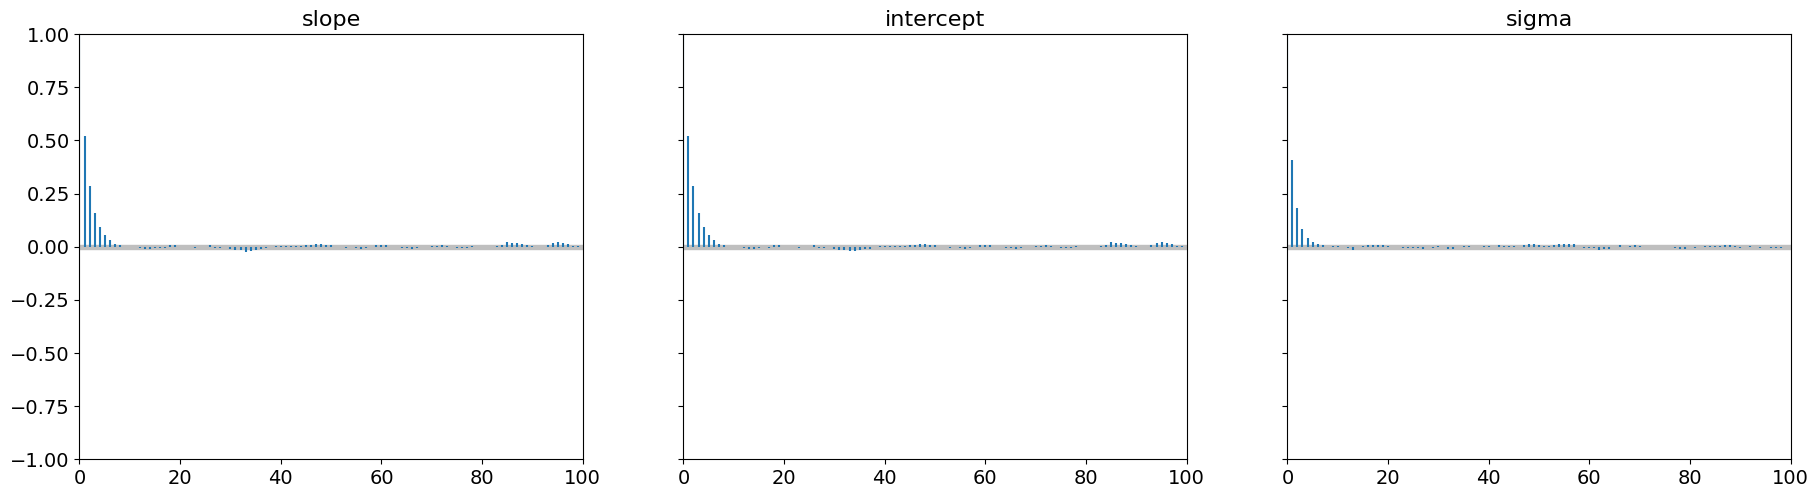

In [65]:
# Autocorrelation Plots
az.plot_autocorr(censored_fit, combined=True)

In [66]:
# Model Summary
summ_censored=az.summary(censored_fit)
summ_censored

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.210,0.006,-0.222,-0.199,0.000,0.000,10609.0,12587.0,1.0
intercept,-2.578,0.121,-2.807,-2.350,0.001,0.001,10615.0,12749.0,1.0
sigma,0.316,0.003,0.311,0.321,0.000,0.000,13896.0,14526.0,1.0


[Text(0.5, 1.0, 'r vs u-r (censored) fit')]

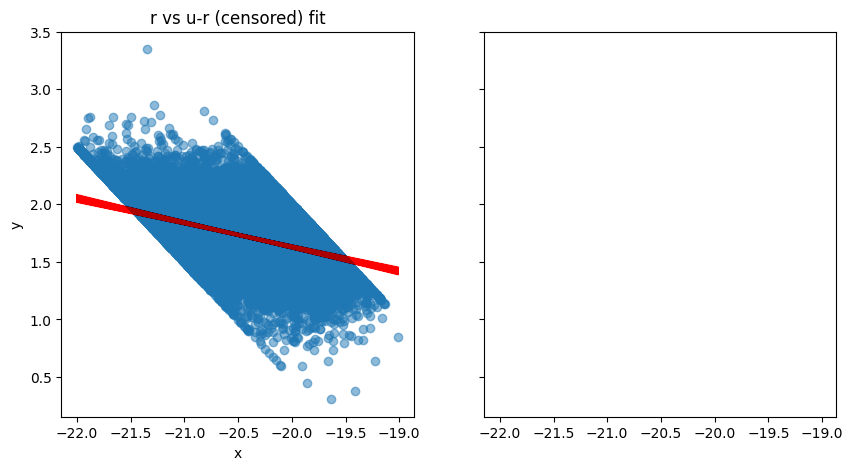

In [67]:
# PLotting best fit line
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (censored) fit")

These are the older charts from when it was just u vs r for reference.
(Sorry, this changed since I re-ran the model -Abby)

In [68]:
summ_censored=az.summary(censored_fit)
summ_censored

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.210,0.006,-0.222,-0.199,0.000,0.000,10609.0,12587.0,1.0
intercept,-2.578,0.121,-2.807,-2.350,0.001,0.001,10615.0,12749.0,1.0
sigma,0.316,0.003,0.311,0.321,0.000,0.000,13896.0,14526.0,1.0


[Text(0.5, 1.0, 'r vs u (censored) fit')]

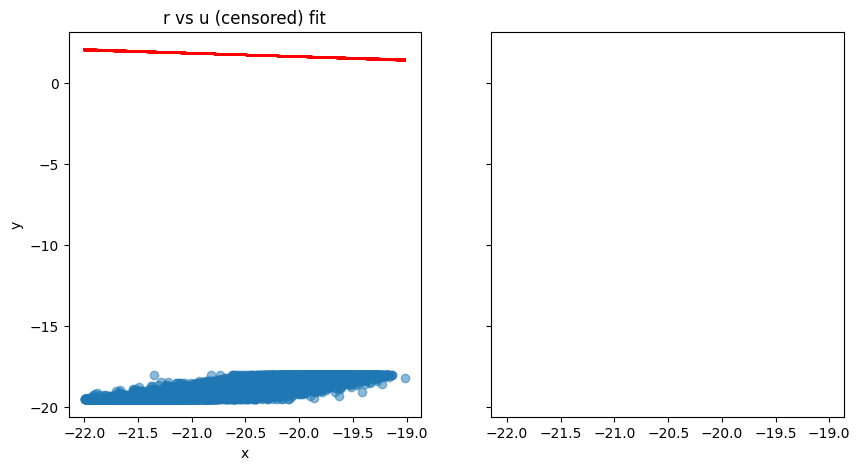

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_uMAG'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u (censored) fit")

# `Prior Predictive Check`

In [70]:
# Prior Predictive Check

# `Posterior Predictive Check`

In [71]:
# Posterior Predictive Check

RANDOM_SEED = 58 
rng = np.random.default_rng(RANDOM_SEED)

with censored_model:
    postdata1 = pm.sample_posterior_predictive(censored_fit, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


In [72]:
postdata1.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 8823)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 8816 8817 8818 8819 8820 8821 8822
Data variables:
    slope      (chain, draw) float64 -0.2134 -0.2123 -0.2102 ... -0.2139 -0.2124
    intercept  (chain, draw) float64 -2.638 -2.62 -2.572 ... -2.732 -2.649 -2.62
    sigma      (chain, draw) float64 0.3148 0.3149 0.3168 ... 0.3169 0.3116
Attributes:
    created_at:                 2023-12-14T00:57:51.751556
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              992.1266028881073
    tuning_steps:               1000

<Axes: xlabel='obs / obs'>

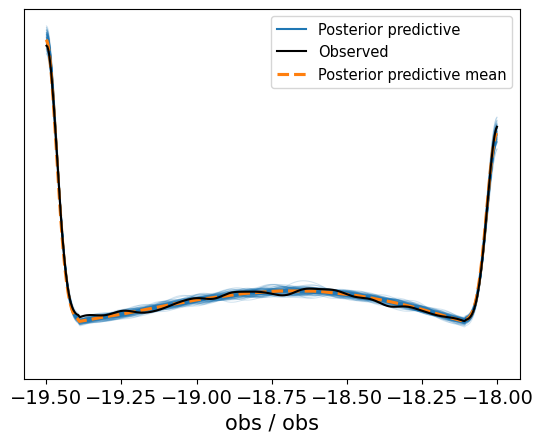

In [73]:
# Not sure how to interpret this yet....
az.plot_ppc(postdata1, num_pp_samples=100)

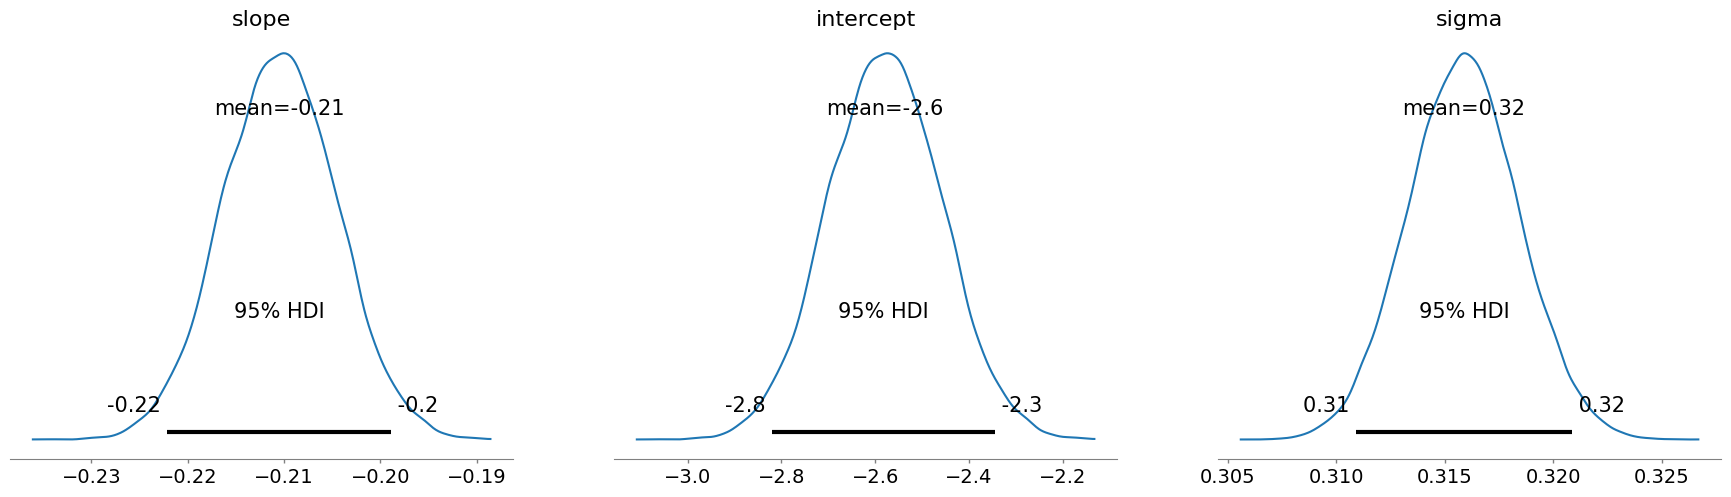

In [74]:
# Posterior Plots with Credible Interval
az.plot_posterior(censored_fit, hdi_prob=.95);


# `Sensitivity Analysis`

/tmp/ipykernel_6099/4108806557.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/4108806557.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=1, sigma=1, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 1737 seconds.


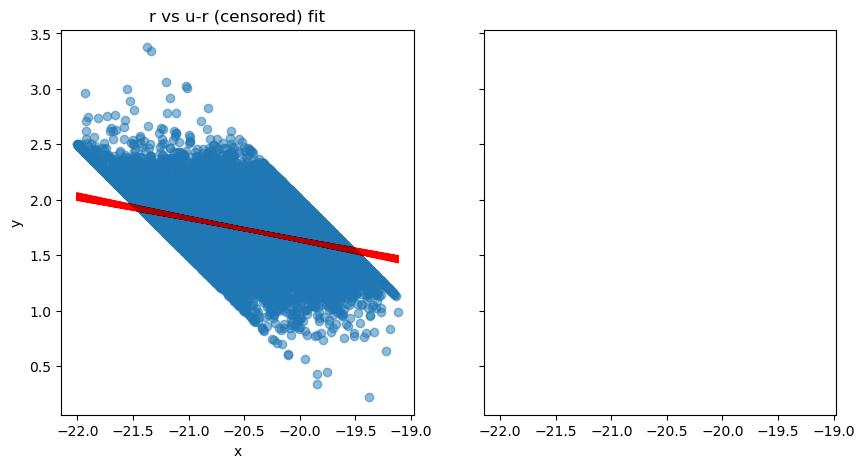

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.195,0.006,-0.206,-0.183,0.000,0.000,11393.0,12854.0,1.0
intercept,-2.263,0.124,-2.502,-2.034,0.001,0.001,11394.0,12993.0,1.0
sigma,0.319,0.003,0.315,0.324,0.000,0.000,14252.0,14564.0,1.0


In [26]:
# Prior slope=1,intercept=1
x = df['rMAG']
y = df['censored_uMAG']
with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=1, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)
# Running MCMC Simulatoins
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(N_sample, init="adapt_diag", step=pm.NUTS())
# PLotting best fit line
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (censored) fit")
plt.show()
az.summary(censored_fit)

/tmp/ipykernel_6099/402090159.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=5, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/402090159.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 644 seconds.


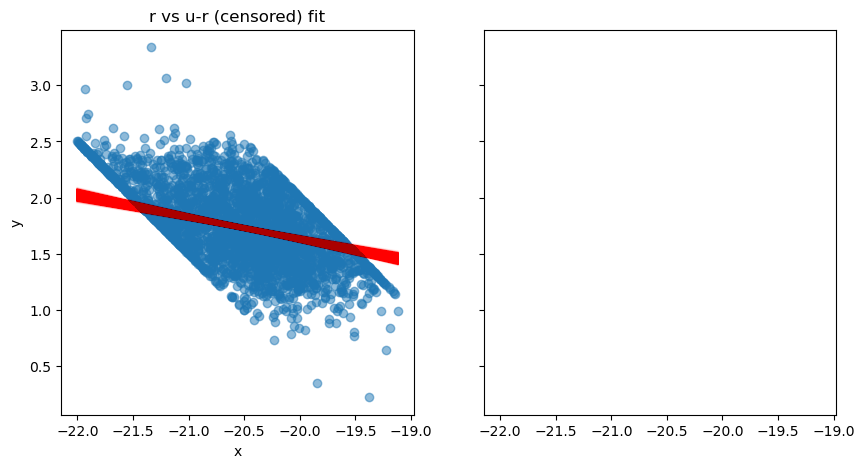

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.196,0.011,-0.217,-0.175,0.000,0.000,10684.0,12065.0,1.0
intercept,-2.293,0.226,-2.734,-1.885,0.002,0.002,10689.0,11881.0,1.0
sigma,0.324,0.005,0.314,0.333,0.000,0.000,14222.0,13606.0,1.0


In [47]:
# Prior slope=5,intercept=5
x = df['rMAG']
y = df['censored_uMAG']
with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=5, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)
# Running MCMC Simulatoins
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(N_sample, init="adapt_diag", step=pm.NUTS())
# PLotting best fit line
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (censored) fit")
plt.show()
az.summary(censored_fit)

/tmp/ipykernel_6099/3683623541.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/3683623541.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 669 seconds.


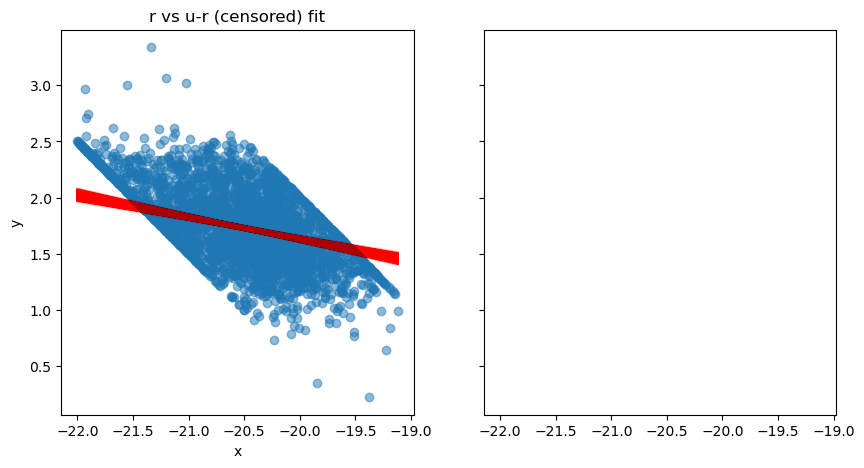

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.196,0.011,-0.216,-0.175,0.000,0.000,9848.0,10415.0,1.0
intercept,-2.287,0.226,-2.719,-1.868,0.002,0.002,9849.0,10451.0,1.0
sigma,0.324,0.005,0.315,0.333,0.000,0.000,14255.0,13479.0,1.0


In [48]:
# Prior slope=1,intercept=5
x = df['rMAG']
y = df['censored_uMAG']
with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)
# Running MCMC Simulatoins
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(N_sample, init="adapt_diag", step=pm.NUTS())
# PLotting best fit line
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (censored) fit")
plt.show()
az.summary(censored_fit)

/tmp/ipykernel_6099/1740721076.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/1740721076.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/tmp/ipykernel_6099/1167654549.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 8_823 draw iterations (4_000 + 35_292 draws total) took 622 seconds.


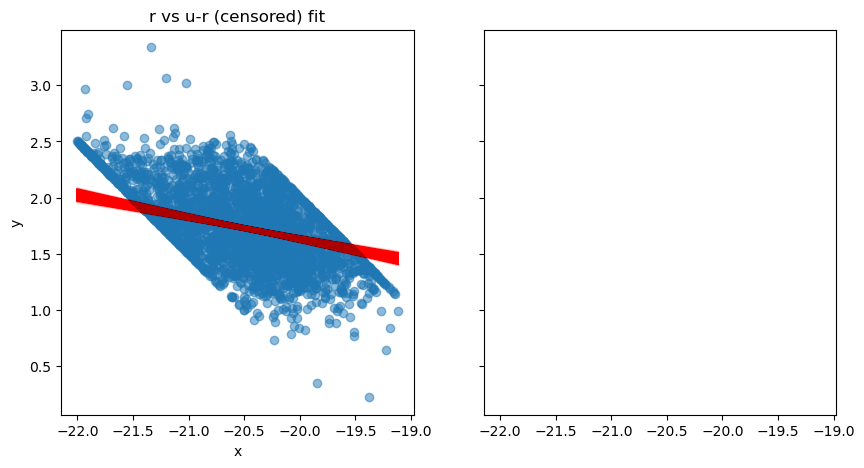

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.196,0.011,-0.216,-0.175,0.000,0.000,10724.0,12333.0,1.0
intercept,-2.288,0.229,-2.708,-1.851,0.002,0.002,10730.0,12374.0,1.0
sigma,0.324,0.005,0.315,0.333,0.000,0.000,13892.0,14058.0,1.0


In [49]:
# Prior slope=5,intercept=1
x = df['rMAG']
y = df['censored_uMAG']
with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=1, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=5, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)
# Running MCMC Simulatoins
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(N_sample, init="adapt_diag", step=pm.NUTS())
# PLotting best fit line
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u-r (censored) fit")
plt.show()
az.summary(censored_fit)